In [1]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax 
import numpy as np
import tensorflow as tf
from scipy import io
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
import time
import os
import tensorflow.keras.backend as K
import pandas as pd
import Modules.utils as utils
import importlib
from scipy.stats import pearsonr

2022-08-03 14:50:01.447145: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [2]:
importlib.reload(utils)
data_dir='../shared_folder'
writing_dir='../shared_folder'
# writing_dir='../'

Read file and datasets checks

In [82]:
with np.load(f'{data_dir}/Bombyx/raw_data/X_long.npz') as f:
    long = f['reads']
with np.load(f'{data_dir}/Bombyx/raw_data/X_reads.npz') as f:
    reads = f['reads']

In [87]:
total = 0
for i in range(len(long)):
    assert(len(long[i]) == len(long[i].rstrip()))
    total += len(long[i])
print(total)
total2 = 0
for i in range(len(reads)):
    assert(len(reads[i]) == len(reads[i].rstrip()))
    total2 += len(reads[i])
print(total2)

66785692
66785692


In [76]:
with np.load(f'{data_dir}/HEK293-ZFAT/raw_data/Control_reads_deduped.npz') as f:
    reads = f['reads']
print(reads.shape)
sequences = utils.remove_reads_with_N(reads, tolerance=0)
print(len(sequences))

(8470220,)
8465615


In [185]:
data = 'CENPT'
model_name = 'model_inception2'
threshold = 0.75
with np.load(f'{data_dir}/{data}/results/{model_name}/seqs_{data}_over_{threshold}_with_{model_name}.npz') as f:
    reads = f['reads']
print(reads.shape)
sequences = utils.remove_reads_with_N(reads, tolerance=0)
print(len(sequences))

(4883,)
4742


In [77]:
dico = utils.check_read_lengths(reads)
dico = dict(sorted(dico.items(), reverse=True))
print('{read_length: nb_reads}')
print(dico)

{read_length: nb_reads}
{101: 5839099, 100: 347449, 99: 182621, 98: 160266, 97: 134119, 96: 108879, 95: 95680, 94: 83252, 93: 76058, 92: 67228, 91: 63067, 90: 59290, 89: 53772, 88: 48981, 87: 46782, 86: 42505, 85: 41757, 84: 40800, 83: 37676, 82: 36773, 81: 34855, 80: 31525, 79: 31469, 78: 30997, 77: 30488, 76: 29807, 75: 42389, 74: 40343, 73: 38426, 72: 34567, 71: 33109, 70: 31529, 69: 31911, 68: 31003, 67: 31177, 66: 30603, 65: 29005, 64: 27739, 63: 28363, 62: 26108, 61: 25977, 60: 26045, 59: 25052, 58: 24169, 57: 25318, 56: 23046, 55: 20134, 54: 19065, 53: 18808, 52: 17963, 51: 16660, 50: 16516}


In [190]:
with np.load(f'{data_dir}/H3K9me3/dataset30M.npz') as f:
    reads = f['x_test']

In [63]:
with np.load(f'{data_dir}/HEK293-ZFAT/raw_data/Control_reads_deduped.npz') as f:
    reads = f['reads']
print(reads.shape)
sequences = utils.remove_reads_with_N(reads, tolerance=0)
print(len(sequences))

print('Looking for read duplicates')
dico = utils.find_duplicates(reads, one_hot=False, batch_size=50_000_000, print_freq=20_000_000)
values = list(dico.values())
print('Looking for duplicate level duplicates')
dico2 = utils.find_duplicates(values, batch_size=100_000_000, print_freq=20_000_000)
dico2 = dict(sorted(dico2.items(), reverse=True))
print('{duplicate_level: nb_unique_reads}')
print(dico2)
print('top 5 duplicate level reads:', list(dico2.keys())[:5])

print('Looking for read duplicates')
dico = utils.find_duplicates(sequences, one_hot=False, batch_size=50_000_000, print_freq=20_000_000)
values = list(dico.values())
print('Looking for duplicate level duplicates')
dico2 = utils.find_duplicates(values, batch_size=100_000_000, print_freq=20_000_000)
dico2 = dict(sorted(dico2.items(), reverse=True))
print('{duplicate_level: nb_unique_reads}')
print(dico2)
print('top 5 duplicate level reads:', list(dico2.keys())[:5])

(8470220,)
8465615
Looking for read duplicates
1 batches
Processing batch 0
seq 8470220/8470220
Looking for duplicate level duplicates
1 batches
Processing batch 0
seq 8470220/8470220 duplicates
{duplicate_level: nb_unique_reads}
{1: 8470220}
top 5 duplicate level reads: [1]
Looking for read duplicates
1 batches
Processing batch 0
seq 8465615/8465615
Looking for duplicate level duplicates
1 batches
Processing batch 0
seq 8465615/8465615 duplicates
{duplicate_level: nb_unique_reads}
{1: 8465615}
top 5 duplicate level reads: [1]


In [61]:
selected_reads = [k for k, v in dico.items() if v == 72]
print(selected_reads)
print(dico[selected_reads[0]])

['CAACAACCGCTATGTATTTCGTACATTACTGCCAGCCACCATGAATATTGTACGGTACCATAAATACTTGACCACCTGTAGTACATAAAAACCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTACAGCAATCAACCCTC']
72


In [26]:
# human telomere sequences
seq_list = [
    'CTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC',
    'CCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA',
    'CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTA',
    'ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCT',
    'TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACC',
    'AACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCC',
    'GGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTA',
    'GTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAG',
    'TTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGG',
    'TAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGG',
    'AGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGT',
    'GGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTT'
]
for seq in seq_list:
    if seq in dico.keys():
        print(dico[seq], seq)
    else:
        print(0, seq)

140 CTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC
41 CCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA
69 CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTA
41 ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCT
13 TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACC
19 AACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCC
34 GGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTA
55 GTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAG
8 TTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGG
5 TAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGG

In [ ]:
x = list(dico.keys())
y = list(dico.values())
plt.plot(x, y)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('occurences')
plt.xlabel('duplicate level')
plt.show()
plt.close()

In [67]:
with np.load(f'{data_dir}/A549G4/dataset4_30M_101bp.npz') as dataset:
    y_train = dataset['y_train']
    y_valid = dataset['y_valid']
    y_test = dataset['y_test']
print('total number of reads:',len(y_train) + len(y_valid) + len(y_test))
print('train:', len(y_train), 'valid:', len(y_valid), 'test:', len(y_test))
print('pos_train:', len(y_train[y_train == 1]), 'pos_valid', len(y_valid[y_valid == 1]), 'pos_test', len(y_test[y_test == 1]))

total number of reads: 59896112
train: 41927278 valid: 8984418 test: 8984416
pos_train: 20963639 pos_valid 4492209 pos_test 4492208


Plot test distribution

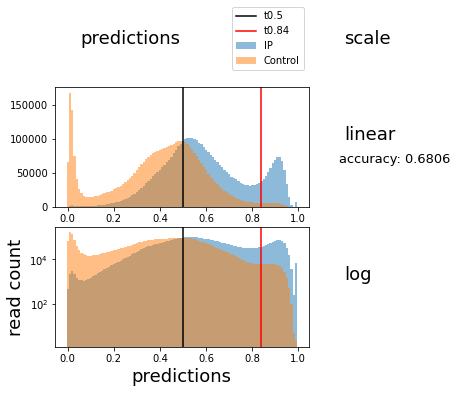

In [39]:
data = 'H3K27ac'
dataset_name = 'dataset4'
model_name = 'model_inception2.2'
load_hist = False
hist_file = f'distrib_{model_name}_test_hist100000'
relabeled = False
new_labels = 'dataset_rel55'
single_pred_array = True
if load_hist:
    with np.load(f'{writing_dir}/{data}/results/{model_name}/{hist_file}.npz') as f:
        histIP = f['IP']
        histControl = f['Control']
    bins = np.linspace(0, 1, len(histIP)+1)
    win_start = 80000
    win_stop = 80100
    histIP, histControl, bins = histIP[win_start:win_stop], histControl[win_start:win_stop], bins[win_start:win_stop+1]
else:
    if single_pred_array:
        if relabeled:
            with np.load(f'{data_dir}/{data}/results/{model_name}/distrib_{model_name}_test_rel.npz') as f:
                preds = f['pred']
            with np.load(f'{data_dir}//{data}/{new_labels}.npz') as f:
                y_test = f['y_test']
        else:
            with np.load(f'{data_dir}/{data}/results/{model_name}/distrib_{model_name}_test.npz') as f:
                preds = f['pred']
            with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
                y_test = f['y_test']
        predIP = preds[y_test == 1]
        predControl = preds[y_test == 0]
    else:
        with np.load(f'{data_dir}/{data}/results/distrib_{model_name}_test.npz') as f:
                predIP = f['predIP']
                predControl = f['predControl']
    accuracy = (len(predIP[predIP > 0.5]) + len(predControl[predControl < 0.5])) / (len(predIP) + len(predControl))
    n_bins = 100
    histIP, bins = np.histogram(predIP, bins=n_bins, range=(0, 1))
    histControl = np.histogram(predControl, bins=n_bins, range=(0, 1))[0]

widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'predictions'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):

    ax0 = plt.subplot(gs[nrow, 0])

    ax0.bar(bins[:-1], histIP, width=np.diff(bins), label='IP', alpha=0.5)
    ax0.bar(bins[:-1], histControl, width=np.diff(bins), label='Control', alpha=0.5)

    if not load_hist:
        ax0.axvline(x=0.5, color='black', label='t0.5')
        thres = 0.84
        ax0.axvline(x=thres, color='red', label=f't{thres}')
    
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        label = 'linear'
        if not load_hist:
            ax1.annotate(f'accuracy: {round(accuracy, 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("predictions", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')

if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.makedirs(f'{writing_dir}/{data}/results/{model_name}')
fig_start = f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test'
fig_name = fig_start + '.png'
fig_dups = 0
while os.path.exists(fig_name):
    fig_dups += 1
    fig_name = fig_start + f'({fig_dups}).png'
plt.savefig(fig_name, bbox_inches='tight')
if not load_hist:
    np.savez(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test_hist{n_bins}', IP=histIP, Control=histControl)
plt.show()
plt.close()

Select sequences

In [40]:
with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
    x_test = f['x_test']
# thres = 0.84
selected_reads = x_test[preds.ravel() > thres, :, :]
print(f'nb of selected reads with thres {thres}:', len(selected_reads))

nb of selected reads with thres 0.84: 760952


In [36]:
with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
    x_test = f['x_test']
thres0 = 0.83
thres1 = 0.99
preds = preds.ravel()
mask = np.logical_and(preds > thres0, preds < thres1)
selected_reads = x_test[mask, :, :]
print(f'nb of selected reads between {thres0} and {thres1}:', len(selected_reads))

nb of selected reads between 0.83 and 0.99: 795243


Write into fasta file

In [41]:
# 3m per 10_000_000 seqs of 101 bp
utils.write_fasta(utils.one_hot_to_seq(selected_reads), f'{writing_dir}/{data}/results/{model_name}/seqs_{data}_over_{thres}_with_{model_name}.fasta')

In [100]:
# 3m per 10_000_000 seqs of 101 bp
utils.write_fasta(utils.one_hot_to_seq(selected_reads), f'{writing_dir}/{data}/results/{model_name}/seqs_{data}_over_{thres0}_below_{thres1}_with_{model_name}.fasta')

Plot training logs

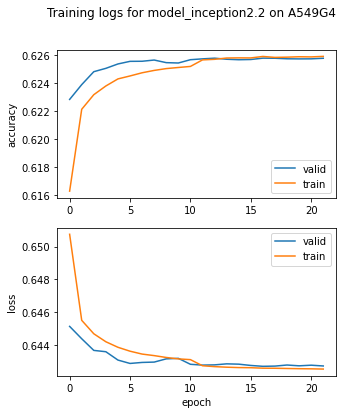

In [23]:
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.mkdir(f'{writing_dir}/{data}/results/{model_name}/')
logs = pd.read_csv(f'{data_dir}/{data}/Trainedmodels/{model_name}/epoch_data.csv')
fig = plt.figure(figsize=(5, 6))
fig.suptitle(f'Training logs for {model_name} on {data}')
ax0 = plt.subplot(211)
ax0.plot(logs['val_accuracy'], label='valid')
ax0.plot(logs['accuracy'], label='train')
ax0.set_ylabel('accuracy')
ax0.legend()

ax1 = plt.subplot(212)
ax1.plot(logs['val_loss'], label='valid')
ax1.plot(logs['loss'], label='train')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
plt.legend()
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/{model_name}_train_log.png', bbox_inches='tight')
plt.show()
plt.close()

In [24]:
IP_accuracy = np.size(predIP[predIP > 0.5]) / np.size(predIP)
Control_accuracy = (np.size(predControl[predControl < 0.5])
                    / np.size(predControl))
print('accuracy: ', (IP_accuracy + Control_accuracy) / 2)
print('IP accuracy: ', IP_accuracy)
print('Control accuracy: ', Control_accuracy)

accuracy:  0.6255333680007693
IP accuracy:  0.5829994960162129
Control accuracy:  0.6680672399853257


Plot test distribution during epochs

16
0.6255769991060075


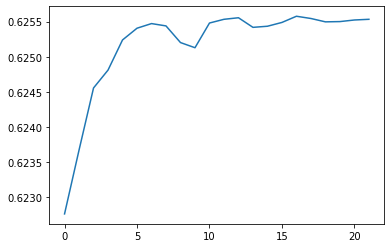

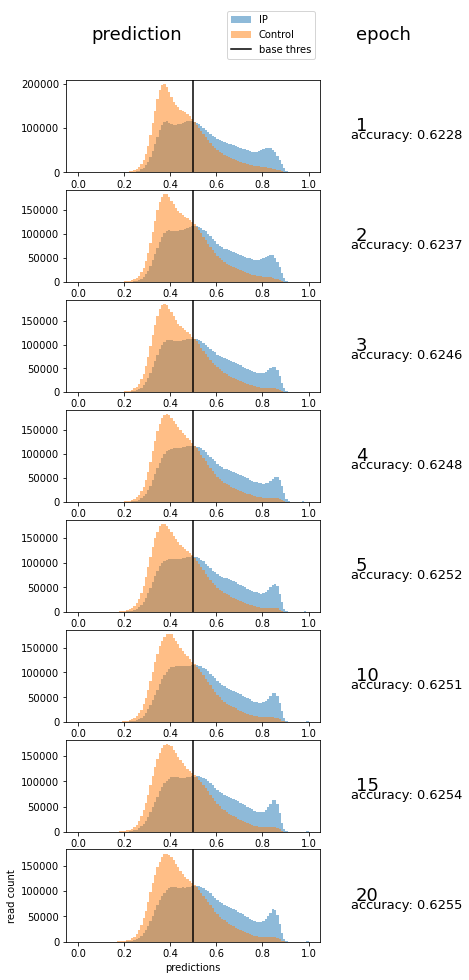

In [25]:
data = 'A549G4'
dataset_name = 'dataset4_30M_101bp'
model_name = 'model_inception2.2'
new_labels = 'dataset_rel55'
relabeled = False
preds = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name}/eval_epochs.npy')
# Watching for nan predictions
# for epoch in range(preds.shape[0]):
#     nans = np.count_nonzero(np.isnan(preds[epoch]))
#     print(f'Epoch {epoch}: {nans} nan predictions')
if relabeled:
    with np.load(f'{data_dir}/{data}/{new_labels}.npz') as f:
        y_test = f['y_test']
else:
    with np.load(f'{data_dir}//{data}/{dataset_name}.npz') as f:
        y_test = f['y_test']


predsIP = preds[:, y_test == 1]
predsControl = preds[:, y_test == 0]
correct_IP = (predsIP > 0.5)
correct_Control = (predsControl < 0.5)
accuracys = (np.sum(correct_IP, axis=1) + np.sum(correct_Control, axis=1)) / len(y_test)
amax = np.argmax(accuracys)
print(amax)
print(accuracys[amax])
plt.plot(accuracys)
plt.show()
plt.close()

# epochs = range(0, preds.shape[0], 5)
epochs = [0, 1, 2, 3, 4, 9, 14, 19]
widths = [5, 1]
heights = [1.2] + [2]*len(epochs)
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} during epochs on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'prediction'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'epoch'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

nrow = 1
for epoch in epochs:
    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(predsIP[epoch], bins=100, label='IP', alpha=0.5, range=(0,1))
    ax0.hist(predsControl[epoch], bins=100, label='Control', alpha=0.5, range=(0,1))
    ax0.axvline(x=0.5, color='black', label='base thres')
    # ax0.set_yscale('log')

    ax1 = plt.subplot(gs[nrow, 1])
    label = f'{epoch+1}'
    ax1.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
    ax1.annotate(f'accuracy: {round(accuracys[epoch], 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    ax1.axis('off')

    nrow += 1

handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')
ax0.set_xlabel("predictions")
ax0.set_ylabel("read count")
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.makedirs(f'{writing_dir}/{data}/results/{model_name}/')
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test_epochs.png', bbox_inches='tight')
plt.show()
plt.close()

Compare predictions between 2 models

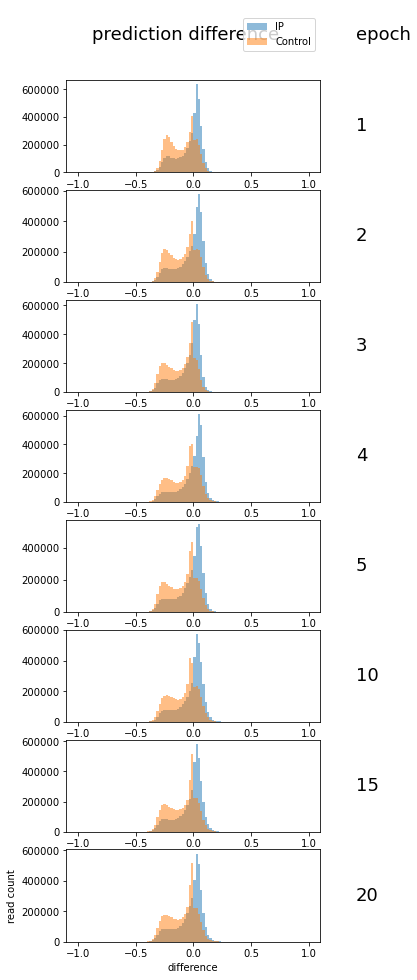

In [22]:
data = 'H3K27ac'
dataset_name = 'dataset4'
model_name = 'model_inception3.0rew'
model_name2 = 'model_inception2.2'
new_labels = 'dataset_rel55'
relabeled = False
preds = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name}/eval_epochs.npy')
preds2 = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name2}/eval_epochs.npy')
diff = preds - preds2

if relabeled:
    with np.load(f'{data_dir}/{data}/{new_labels}.npz') as f:
        y_test = f['y_test']
else:
    with np.load(f'{data_dir}//{data}/{dataset_name}.npz') as f:
        y_test = f['y_test']

diffIP = diff[:, y_test == 1]
diffControl = diff[:, y_test == 0]

# epochs = range(0, preds.shape[0], 5)
epochs = [0, 1, 2, 3, 4, 9, 14, 19]
widths = [5, 1]
heights = [1.2] + [2]*len(epochs)
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of prediction differences of {model_name} during epochs on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'prediction difference'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'epoch'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

nrow = 1
for epoch in epochs:
    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(diffIP[epoch], bins=100, label='IP', alpha=0.5, range=(-1, 1))
    ax0.hist(diffControl[epoch], bins=100, label='Control', alpha=0.5, range=(-1, 1))
    # ax0.set_yscale('log')

    ax1 = plt.subplot(gs[nrow, 1])
    label = f'{epoch+1}'
    ax1.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')

    nrow += 1

handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')
ax0.set_xlabel("difference")
ax0.set_ylabel("read count")
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.mkdir(f'{writing_dir}/{data}/results/{model_name}/')
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_vs_{model_name2}_test_epochs.png', bbox_inches='tight')
plt.show()
plt.close()

Plot GC_content distribution

accuracy : 0.5815824585517009


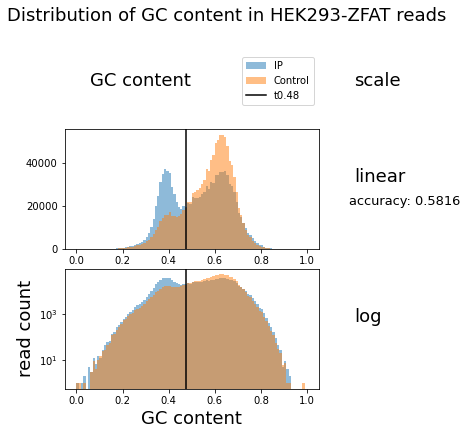

In [30]:
data='HEK293-ZFAT'
dataset_name='dataset4'
with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
    x_test = f['x_test']
    y_test = f['y_test']
gc_content = utils.GC_content(x_test)

bins = np.histogram(gc_content, bins=100, range=(0, 1))[1]
accuracy, thres = utils.classify_1D(gc_content, y_test, bins=100)
print('accuracy :', accuracy)

widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'GC content'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):

    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(gc_content[y_test == 1], bins, label='IP', alpha=0.5)
    ax0.hist(gc_content[y_test == 0], bins, label='Control', alpha=0.5)
    ax0.axvline(x=thres, color='black', label=f't{round(thres, 2)}')
    
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        scale_label = 'linear'
        ax1.annotate(f'accuracy: {round(accuracy, 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        scale_label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(scale_label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("GC content", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')

fig.suptitle(f'Distribution of GC content in {data} reads', fontsize=18)
plt.savefig(f'{writing_dir}/{data}/results/gc_content_classification_{dataset_name}.png', bbox_inches='tight')
plt.show()
plt.close()

Load chromosome

In [3]:
importlib.reload(utils)
chr_id = 1
chr_file = f'../shared_folder/Human/assembly/chr{chr_id}.npz'
with np.load(chr_file) as f:
    one_hot_chr = f['one_hot_genome']
window_size = 101
valid_window_idx = utils.remove_windows_with_N(one_hot_chr, window_size)
print('All windows:', len(one_hot_chr)-window_size+1)
print('Without N:', len(valid_window_idx))

All windows: 248956322
Without N: 230469111


Load predictions

In [5]:
with np.load(f'../shared_folder/H3K27ac/results/model_inception2.2/preds_model_inception2.2_on_chr{chr_id}.npz') as f:
    preds0 = f['preds']
with np.load(f'../shared_folder/H3K27ac/results/model_inception2.2.rep1/preds_model_inception2.2.rep1_on_chr{chr_id}.npz') as f:
    preds1 = f['preds']
# with np.load(f'../shared_folder/H3K27ac/results/model_inception2.2/preds_on_genome.npz') as f:
#     preds0 = f[f'chr{chr_id}']
# with np.load(f'../shared_folder/H3K27ac/results/model_inception2.2.rep1/preds_on_genome.npz') as f:
#     preds1 = f[f'chr{chr_id}']

In [38]:
importlib.reload(utils)
# z-score, mean and smooth
preds = (preds0 + preds1)/2  # mean
z_score_preds = utils.z_score(preds, valid_window_idx)
z_score_preds0 = utils.z_score(preds0, valid_window_idx)
z_score_preds1 = utils.z_score(preds1, valid_window_idx)
# Smooth mean
smooth_size = window_size
z_score_smooth = utils.smooth(z_score_preds, smooth_size, mode='linear')

# mean and std with or without windows containing Ns
mean = np.mean(preds)
std = np.std(preds)
rel_preds = preds[valid_window_idx]
rel_mean = np.mean(rel_preds)
rel_std = np.std(rel_preds)
print('mean and std for all windows:', mean, std)
print('mean and std without Ns:', rel_mean, rel_std)

# correlations between replicas
inter_corr = pearsonr(preds0, preds1)
print(inter_corr, 'correlation rep0-rep1')
corr_0m = pearsonr(preds0, preds)
print(corr_0m, 'correlation rep0-mean')
corr_1m = pearsonr(preds, preds1)
print(corr_1m, 'correlation rep1-mean')
corr_m_smth = pearsonr(z_score_preds, z_score_smooth)
print(corr_m_smth)

mean and std for all windows: 0.41031668 0.18861058
mean and std without Ns: 0.4355817 0.17270145
(0.9466851160107389, 0.0) correlation rep0-rep1
(0.9852065091722209, 0.0) correlation rep0-mean
(0.9878893875329986, 0.0) correlation rep1-mean
(0.914130111772974, 0.0)


Load peaks, logFC and p-value

In [33]:
importlib.reload(utils)
peaks_dict = utils.parse_bed_peaks('../shared_folder/H3K27ac/raw_data/peaks/ENCFF553YTG.bed')
p_vals = utils.load_annotation('../shared_folder/H3K27ac/raw_data/p_value/ENCFF472QZS.bigWig', chr_id, window_size)
log_fc = utils.load_annotation('../shared_folder/H3K27ac/raw_data/logFC/ENCFF408XBB.bigWig', chr_id, window_size)

peaks_CTCF_dict = utils.parse_bed_peaks('../shared_folder/CTCF/raw_data/peaks/ENCFF748YHT.bed')
p_vals_CTCF = utils.load_annotation('../shared_folder/CTCF/raw_data/p_value/ENCFF701JJR.bigWig', chr_id, window_size)
log_fc_CTCF = utils.load_annotation('../shared_folder/CTCF/raw_data/logFC/ENCFF902EIC.bigWig', chr_id, window_size)

In [39]:
# Total peaks and only high ones
chr1_peaks = peaks_dict['1']
print(chr1_peaks.shape, 'total peaks')
high_peaks = chr1_peaks[chr1_peaks[:,2] >= 1000]
print(high_peaks.shape, 'high peaks')
# Peaks of different dataset
chr1_CTCF_peaks = peaks_CTCF_dict['1']
print(chr1_CTCF_peaks.shape, 'total peaks in other dataset')
high_CTCF_peaks = chr1_CTCF_peaks[chr1_CTCF_peaks[:,2] >= 1000]
print(high_CTCF_peaks.shape, 'high peaks in other dataset')

# Correlation between fold change and predicitons
corr_mean = pearsonr(z_score_preds, log_fc)
print(corr_mean, 'correlation mean-logFC')
corr_smooth = pearsonr(z_score_smooth, log_fc)
print(corr_smooth, 'correlation smooth-logFC')
corr_0 = pearsonr(z_score_preds0, log_fc)
print(corr_0, 'correlation rep0-logFC')

# Correlation with other dataset
corr_FC = pearsonr(log_fc, log_fc_CTCF)
print(corr_FC, 'correlation logFC CTCF-H3K27ac')
corr_p_val = pearsonr(p_vals, p_vals_CTCF)
print(corr_p_val, 'correlation p_vals CTCF-H3K27ac')

(4570, 3) total peaks
(1968, 3) high peaks
(9312, 3) total peaks in other dataset
(7937, 3) high peaks in other dataset
(0.22032916311865566, 0.0) correlation mean-logFC
(0.24627603364713846, 0.0) correlation smooth-logFC
(0.22243137782338354, 0.0) correlation rep0-logFC
(0.052425185662290756, 0.0) correlation logFC CTCF-H3K27ac
(0.037997195432002126, 0.0) correlation p_vals CTCF-H3K27ac


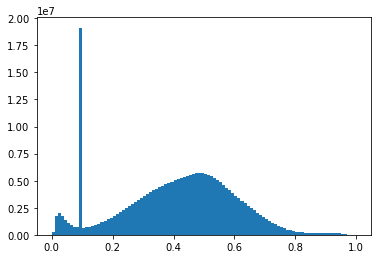

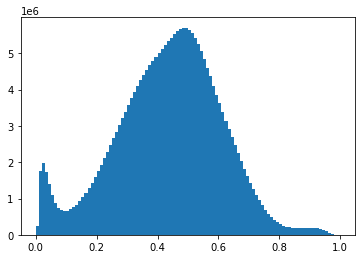

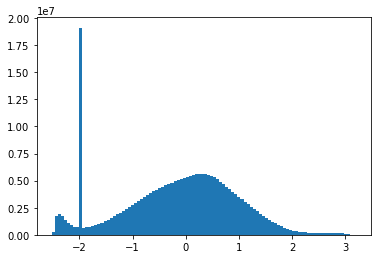

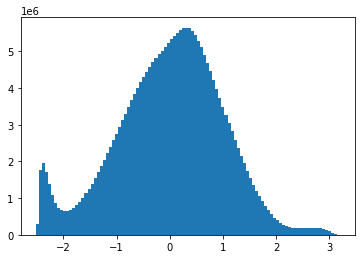

In [40]:
# Distribution of predictions on all windows
plt.hist(preds, bins=100, range=(0, 1))
plt.show()
plt.close()
# Distribution of predictions on N free windows
plt.hist(rel_preds, bins=100, range=(0, 1))
plt.show()
plt.close()
# Same for z-score
plt.hist(z_score_preds, bins=100)
plt.show()
plt.close()
plt.hist(z_score_preds[valid_window_idx], bins=100)
plt.show()
plt.close()

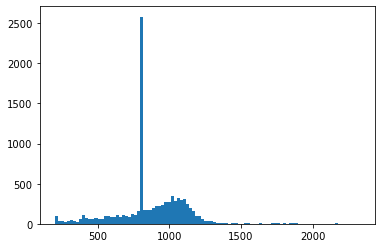

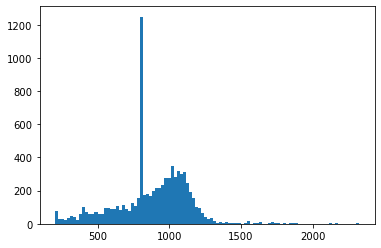

In [41]:
# Distribution of peak lengths
peak_lengths = np.diff(chr1_CTCF_peaks[:, :2], axis=1).ravel()
high_peaks_lengths = np.diff(high_CTCF_peaks[:, :2], axis=1).ravel()
plt.hist(peak_lengths, bins=100)
plt.show()
plt.close()
plt.hist(high_peaks_lengths, bins=100)
plt.show()
plt.close()

In [67]:
strange_CTCF_peaks = chr1_CTCF_peaks[peak_lengths == 810]
print(strange_CTCF_peaks.shape, 'strange peaks')
strange_peaks_indices = strange_CTCF_peaks[:, :1] + np.expand_dims(np.arange(810), axis=0)
strange_peaks_one_hot = one_hot_chr[strange_peaks_indices]
strange_peaks_seq = utils.one_hot_to_seq(strange_peaks_one_hot)
utils.write_fasta(strange_peaks_seq, '../shared_folder/CTCF/raw_data/peaks/strange_peaks_seqs.fasta')

(2440, 3) strange peaks


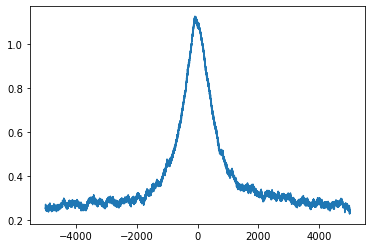

In [75]:
# Metaplot of predictions over mid peaks
importlib.reload(utils)
mid_peaks = (chr1_peaks[:, 0] + chr1_peaks[:, 1]) // 2
window_half_size = 5000
means, window = utils.metaplot_over_indices(z_score_preds, mid_peaks - window_size // 2, window_half_size)

[100037491 100039259      1000]


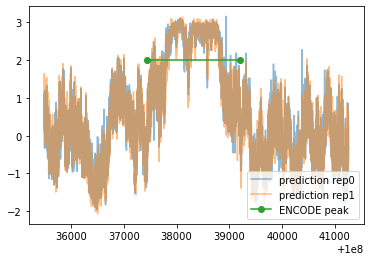

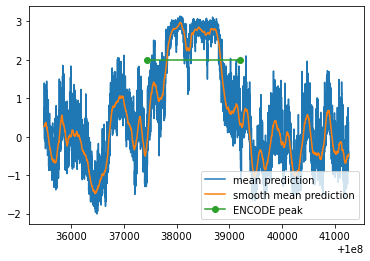

In [101]:
# plot of predictions over chosen peak
i = 2
print(chr1_peaks[i])
peak_start, peak_end, score = chr1_peaks[i]
window = np.arange(peak_start-2000, peak_end+2000)
# both replicas
plt.plot(window, z_score_preds0[window], label='prediction rep0', alpha=0.5)
plt.plot(window, z_score_preds1[window], label='prediction rep1', alpha=0.5)
plt.plot([peak_start - window_size // 2, peak_end - window_size // 2], [2, 2], marker = 'o', label='ENCODE peak')
plt.legend(loc='lower right')
plt.show()
plt.close()
# mean vs smooth mean
importlib.reload(utils)
z_score_smooth = utils.smooth(z_score_preds, window_size, mode='linear')
plt.plot(window, z_score_preds[window], label='mean prediction')
plt.plot(window, z_score_smooth[window], label='smooth mean prediction')
plt.plot([peak_start - window_size // 2, peak_end - window_size // 2], [2, 2], marker = 'o', label='ENCODE peak')
plt.legend(loc='lower right')
plt.show()
plt.close()

(9760, 2) peaks found


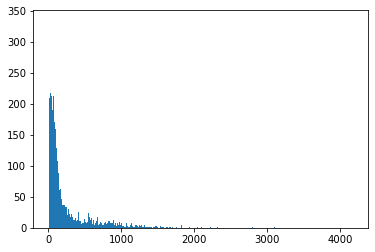

In [76]:
importlib.reload(utils)
# Find peaks in prediction with custom function and plot lengths
peaks = utils.find_peaks(z_score_smooth, pred_thres=2, length_thres=3, tol=0)
lengths = np.sort(np.diff(peaks, axis=1).ravel())
distances = np.sort(peaks[1:, 0] - peaks[:-1, 1])  # check distances between peaks
print(peaks.shape, 'peaks found')
MAX = 1000
plt.hist(lengths, bins=MAX+1)#, range=(-0.5, MAX+0.5))
# plt.yscale('log')
# plt.xscale('log')
plt.show()
plt.close()

[100037491 100039259      1000]


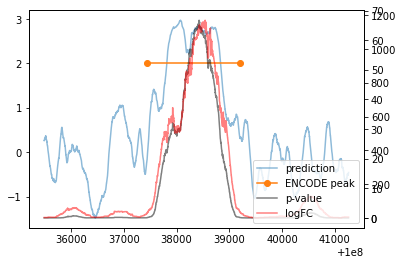

In [55]:
# plot prediction signal vs fold change and p-value
i = 2
print(chr1_peaks[i])
peak_start, peak_end, score = chr1_peaks[i]
window = np.arange(peak_start-2000, peak_end+2000)
ax1 = plt.subplot()
ax1.plot(window, z_score_smooth[window], label='prediction', alpha=0.5)
ax1.plot([peak_start - window_size // 2, peak_end - window_size // 2], [2, 2], marker = 'o', label='ENCODE peak')
ax2 = ax1.twinx()
ax2.plot(window, p_vals[window], label='p-value', alpha=0.5, color='black')
ax3 = ax1.twinx()
ax3.plot(window, log_fc[window], label='logFC', alpha=0.5, color='red')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3, loc='lower right')
plt.show()
plt.close()